# Automatic estimation of the flux and velocity and double sinc fit

The following example shows how to make a quick estimate of the flux + velocity. The NGC6888 shell displays two generally unresolved components which can be fitted with a double sinc model thanks to the generally high SNR of the data.

In [6]:
from orcs. process import SpectralCube
import orb.utils.io as io
import pylab as pl
import numpy as np
import orb.utils.graph as graph

In [3]:
cube = SpectralCube('/home/thomas/data/NGC6888_North_SN3.merged.cm1.1.0.hdf5')

dev.3ea5|INFO| Cube is level 3
dev.3ea5|INFO| shape: (2048, 2064, 506)
dev.3ea5|INFO| wavenumber calibration: True
dev.3ea5|INFO| flux calibration: True
dev.3ea5|INFO| wcs calibration: True


In [4]:
cube.params.resolution

2852.798103935495

In [69]:
df = cube.get_deep_frame()
df.to_fits('deep_frame.fits')

dev.f573|INFO| Data written as deep_frame.fits in 0.10 s 


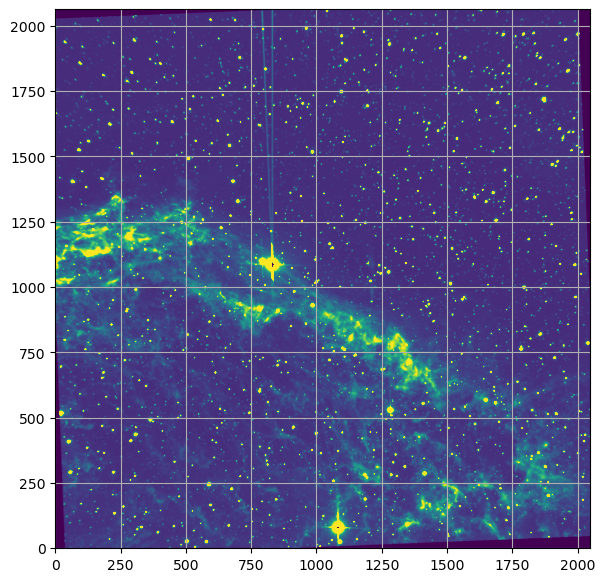

In [9]:
df.imshow(perc=99, wcs=None)
pl.grid()

## check some random spectra

dev.3ea5|INFO| estimated velocities: [-1.7588293232024625, nan]


(14750.0, 15400.0)

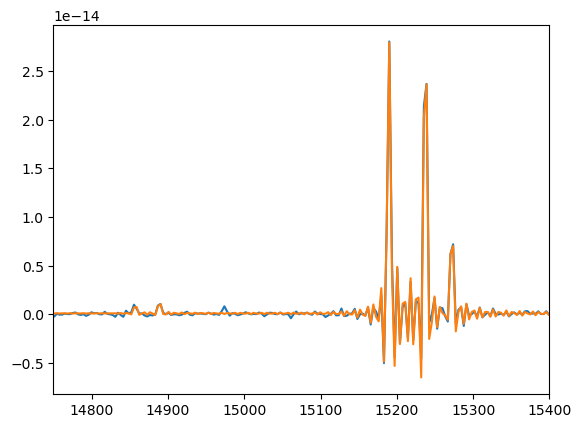

In [28]:
spec = cube.get_spectrum(1500, 250, 5)
#spec = cube.get_spectrum(550, 125, 5)
#spec = cube.get_spectrum(675,521, 5)
fit = spec.autofit(lines, vel_range=[-2500,2500], max_comps=2, threshold=3, prod=True,precision=100)
pl.figure()
spec.plot()
fit.get_spectrum().plot()
pl.xlim(14750, 15400)

## estimate velocity everywhere

In [17]:
region = 'polygon(-83.32082,1404.5042,517.27761,1658.3654,1216.9438,1175.4099,2201.4299,704.83797,2096.1704,-38.170401,-27.595192,-62.937347)'
lines = ['[NII]6548', '[NII]6584', 'Halpha', '[SII]6717', '[SII]6731']

In [16]:
cube.estimate_parameters_in_region(region, lines, 
                                   vel_range=[-2500,2500], max_comps=3, threshold=3)

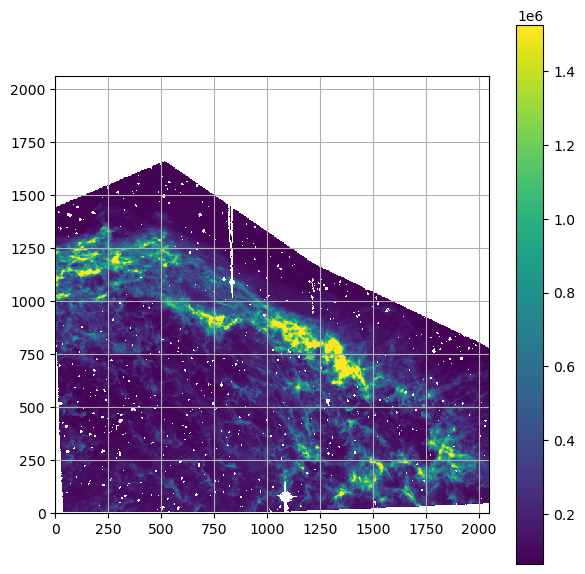

In [10]:
graph.imshow(io.read_fits('NGC6888_North_SN3/NGC6888_North_SN3.SpectralCube.estimated_Halpha.0.fits'), interpolation='nearest')
pl.colorbar()
pl.grid()

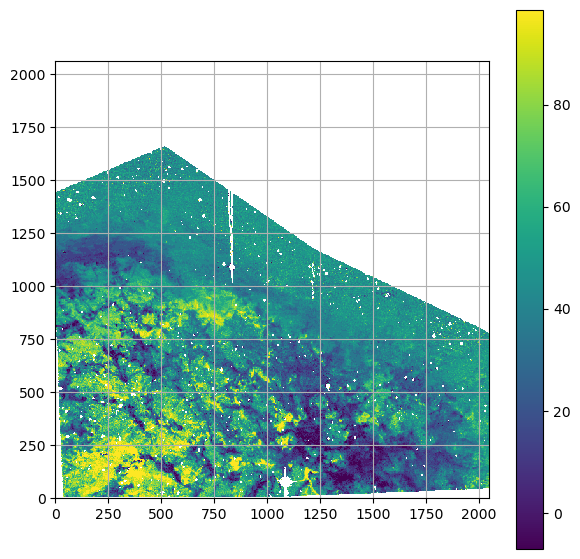

In [24]:
velmap = io.read_fits('NGC6888_North_SN3/NGC6888_North_SN3.SpectralCube.estimated_velocity.0.fits')
graph.imshow(velmap, interpolation='nearest')
pl.colorbar()
pl.grid()

## check fitting parameters

In [30]:
velmap = io.read_fits('NGC6888_North_SN3/NGC6888_North_SN3.SpectralCube.estimated_velocity.0.fits')

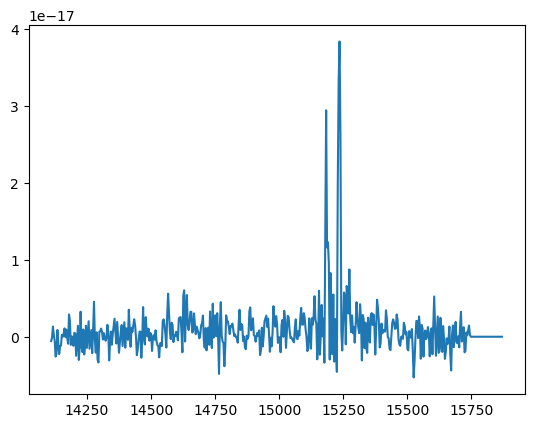

In [78]:
#ix,iy = 1500,250 # somehow larger than pure sinc
#ix,iy = 574,93 # somehow larger than pure sinc
ix,iy = 675,521 # two clearly resolved components
spec = cube.get_spectrum(ix,iy,0)
spec.plot()

=== Fit results ===
lines: ['[NII]6548', '[NII]6584', 'H3', '[SII]6717', '[SII]6731'], fmodel: sincgauss
iterations: 169, fit time: 3.75e-01 s
number of free parameters: 7, BIC: -1.95875e+04, chi2: 5.30e+35
Velocity (km/s): [68.4(4.5) 68.4(4.5) 68.4(4.5) 68.4(4.5) 68.4(4.5)] 
Flux: [3.20(31)e-17 9.54(94)e-17 1.80(13)e-16 1.01(82)e-17 1.8(8.2)e-18]
Broadening (km/s): [84.3(4.6) 84.3(4.6) 84.3(4.6) 84.3(4.6) 84.3(4.6)]
SNR (km/s): [12.1029742  12.1029742  19.78560767  1.23540797  0.21401056]



(15100.0, 15300.0)

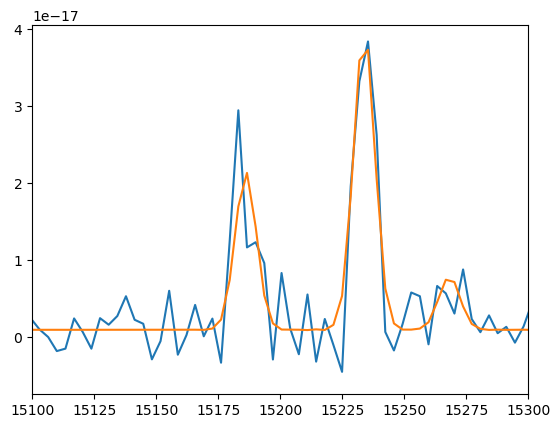

In [79]:
# try sincgauss model
amp_ratio = cube.get_amp_ratio_from_flux_ratio('[NII]6583', '[NII]6548', 3)

amp_def = (1,1,2,3,4)
amp_guess = (1, amp_ratio, 1, 1, 1)
    
fit = spec.fit(lines, pos_def='1', 
               pos_cov=velmap[ix,iy], 
               fmodel='sincgauss', 
               sigma_def='1',
               sigma_cov=50,
               amp_def=amp_def,
               amp_guess=amp_guess)
spec.plot()
fit.get_spectrum().plot()
print(fit)
pl.xlim(15100, 15300)

=== Fit results ===
lines: ['[NII]6548', '[NII]6584', 'H3', '[SII]6717', '[SII]6731', '[NII]6548', '[NII]6584', 'H3', '[SII]6717', '[SII]6731'], fmodel: sinc
iterations: 157, fit time: 2.39e-01 s
number of free parameters: 11, BIC: -1.96703e+04, chi2: 3.49e+35
Velocity (km/s): [128.3(2.2) 128.3(2.2) 128.3(2.2) 128.3(2.2) 128.3(2.2) 10.8(2.4)
 10.8(2.4) 10.8(2.4) 10.8(2.4) 10.8(2.4)] 
Flux: [1.87(11)e-17 5.61(33)e-17 7.46(35)e-17 3.5(3.6)e-18 -5(366)e-20
 1.05(11)e-17 3.14(33)e-17 8.12(35)e-17 3.5(3.6)e-18 -5(37)e-19]
Broadening (km/s): [nan +- nan nan +- nan nan +- nan nan +- nan nan +- nan nan +- nan
 nan +- nan nan +- nan nan +- nan nan +- nan]
SNR (km/s): [ 1.68178043e+01  1.68178043e+01  2.13511602e+01  9.60421679e-01
 -1.37466578e-02  9.41957769e+00  9.41957769e+00  2.32646023e+01
  9.61604832e-01 -1.27989625e-01]



(15100.0, 15300.0)

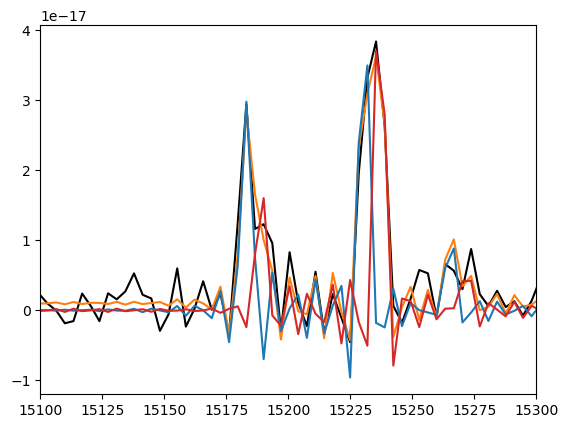

In [80]:
# try double sinc model
fit = spec.fit(lines + lines, 
               pos_def=5*['1',] + 5*['2',], 
               pos_cov=(velmap[ix,iy]+10, velmap[ix,iy]-10),
               amp_def=amp_def + tuple(np.array(amp_def) + 10),
               amp_guess=amp_guess+amp_guess)
print(fit)
spec.plot(c='black')
fit.get_spectrum().plot(c='tab:orange')

i = 0
comp0 = np.zeros_like(spec.data.real)
comp1 = np.zeros_like(spec.data.real)
for i, imod in zip(range(10), fit['fitted_models']['Cm1LinesModel']):
    if i<5: comp0 += imod
    else: comp1 += imod
    
pl.plot(spec.axis.data, comp0, c='tab:blue')
pl.plot(spec.axis.data, comp1, c='tab:red')
    
pl.xlim(15100, 15300)

## fit an entire region of the cube

In [ ]:
region = 'circle(675,521,30)'
cube.fit_lines_in_region(region,
                         lines + lines, 
                         pos_def=5*['1',] + 5*['2',], 
                         pos_cov_map=(velmap+10, velmap-10), # note the '_map' suffix
                         amp_def=amp_def + tuple(np.array(amp_def) + 10),
                         amp_guess=amp_guess+amp_guess)